<a href="https://colab.research.google.com/github/sudhanshu105/WeatherModel/blob/main/Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

weather = pd.read_csv("/content/sample_data/weather.csv", index_col="DATE")

In [ ]:
weather

In [3]:
null_pct = weather.apply(pd.isnull).sum()/weather.shape[0]

In [ ]:
null_pct

In [5]:
valid_columns= weather.columns[null_pct< .05]

In [ ]:
valid_columns

In [7]:
weather = weather[valid_columns].copy()

In [8]:
weather=weather.ffill()

In [ ]:
weather.apply(pd.isnull).sum()

In [ ]:
weather.dtypes

In [ ]:
weather.index

In [13]:
weather.index = pd.to_datetime(weather.index)

In [ ]:
weather["SNWD"].plot()

In [16]:
weather["target"]=weather.shift(-1)["TMAX"]

In [ ]:
weather

In [19]:
weather=weather.ffill()

In [21]:
from sklearn.linear_model import Ridge
rr= Ridge(alpha=.1)

In [24]:
predictors= weather.columns[~weather.columns.isin(["target", "NAME", "STATION"])]

In [ ]:
predictors

In [28]:
def backtest(weather, model, predictors, start=3650, step=90):
    all_predictions = []

    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]

        model.fit(train[predictors], train["target"])

        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [29]:
predictions = backtest(weather,rr, predictors)

In [30]:
predictions

,actual,prediction,diff
DATE,,,
1979-12-30,43.0,50.229324,7.229324
1979-12-31,42.0,43.673798,1.673798
1980-01-01,41.0,41.579150,0.579150
1980-01-02,36.0,43.961887,7.961887
1980-01-03,30.0,40.204726,10.204726
...,...,...,...
2022-10-17,58.0,67.543412,9.543412
2022-10-18,56.0,60.511771,4.511771
2022-10-19,61.0,57.030435,3.969565


In [31]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(predictions["actual"],predictions["prediction"])

5.139326679660841

In [32]:
predictions["diff"].mean()

5.139326679660841

In [34]:
def pct_diff(old,new):
  return (new-old)/old

def compute_rolling(weather, horizon, col):
  label= f"rolling_{horizon}_{col}"
  weather[label]=weather[col].rolling(horizon).mean()
  weather[f"{label}_pct"]= pct_diff(weather[label],weather[col])
  return weather

rolling_horizons = [3, 14]
for horizon in rolling_horizons:
    for col in ["TMAX", "TMIN", "PRCP"]:
        weather = compute_rolling(weather, horizon, col)

In [ ]:
weather

In [36]:
weather= weather.iloc[14:,:]

In [38]:
weather=weather.fillna(0)

In [40]:
def expand_mean(df):
    return df.expanding(1).mean()

for col in ["TMAX", "TMIN", "PRCP"]:
    weather[f"month_avg_{col}"] = weather[col].groupby(weather.index.month, group_keys=False).apply(expand_mean)
    weather[f"day_avg_{col}"] = weather[col].groupby(weather.index.day_of_year, group_keys=False).apply(expand_mean)

In [ ]:
weather

In [43]:
predictors = weather.columns[~weather.columns.isin(["target", "NAME", "STATION"])]

In [ ]:
predictors

In [45]:
predictions= backtest(weather,rr,predictors)

In [ ]:
predictions

In [ ]:
mean_absolute_error(predictions["actual"],predictions["prediction"])

In [ ]:
predictions.sort_values("diff",ascending=False)

In [ ]:
weather.loc["1990-03-07":"1990-03-17"]

<Axes: xlabel='diff'>

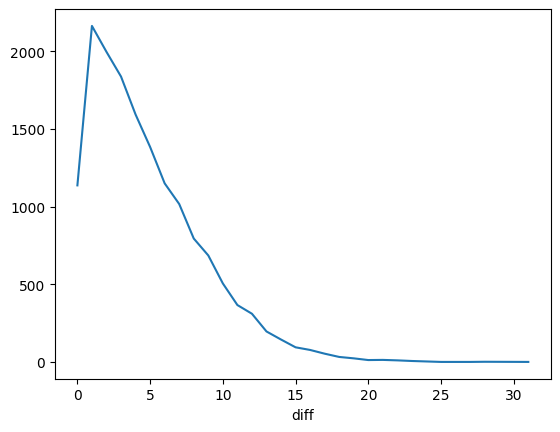

In [52]:
predictions["diff"].round().value_counts().sort_index().plot()